# Studies on VBF jet selection's signal efficiency

Authors: Zichun Hao and Raghav Kansal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import numpy as np

import uproot
import awkward as ak
from coffea import nanoevents

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup
from tqdm import tqdm

from HHbbVV.processors.utils import pad_val

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 24})

import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from pathlib import Path

MAIN_DIR = Path("../../../")
DATA_DIR = MAIN_DIR.resolve().parent / "data"
# samples_dir = "/ceph/cms/store/user/annava/projects/HHbbVV/24Mar5AllYears"

# date = "24Mar6"
date = datetime.now().strftime("%Y%m%d")
plot_dir = MAIN_DIR / f"plots/Kinematics/{date}"
plot_dir.mkdir(parents=True, exist_ok=True)

Look at single SM VBF HH signal NanoAOD file

In [3]:
# events = nanoevents.NanoEventsFactory.from_root(
#     # "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
#     str(DATA_DIR / "vbf.root"),
#     # f,
#     schemaclass=nanoevents.NanoAODSchema,
# ).events()
files = {
    "vbf": "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
    "qcd": "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/QCD/QCD_HT1500to2000_TuneCP5_PSWeights_13TeV-madgraph-pythia8/QCD_HT1500to2000_PSWeights_madgraph/220808_163124/0000/nano_mc2018_1-1.root",
    "tt": "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/TTbar/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/TTToHadronic/220808_151154/0000/nano_mc2018_1-1.root",
}

events_dict = {}

for key, file in files.items():
    events_dict[key] = nanoevents.NanoEventsFactory.from_root(
        file, schemaclass=nanoevents.NanoAODSchema
    ).events()

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
b_PDGID = 5
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

## Generator Level Studies

Get generator-level Higgs and Vs

In [4]:
events = events_dict["vbf"]
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

higgs_children = higgs.children

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.any(is_bb, axis=2)]
HVV = higgs[ak.any(is_VV, axis=2)]

# make sure we're only getting one Higgs
Hbb = ak.pad_none(Hbb, 1, axis=1)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1)[:, 0]

vs = events.GenPart[((abs(events.GenPart.pdgId) == 24)) * events.GenPart.hasFlags(GEN_FLAGS)]

# vbf output quarks are always at index 4, 5
gen_quarks = events.GenPart[events.GenPart.hasFlags(["isHardProcess"])][:, 4:6]

Check gen-level plots

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(np.abs(gen_quarks.eta)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$|\eta_{q}|$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_eta.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(gen_quarks.pt), np.arange(0, 1010, 10), histtype="step", density=True)
plt.xlabel(r"$p_{Tq}$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_pt.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(Hbb.delta_r(gen_quarks)), np.arange(0, 9, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, Hbb)$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_Hbb_dr.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(HVV.delta_r(gen_quarks)), np.arange(0, 9, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, HVV)$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_HVV_dr.pdf", bbox_inches="tight")
plt.show()

## Baseline Selections

In [5]:
num_jets = 2
sel_dict = {}
bbjet_dict = {}
vvjet_dict = {}

for key, events in events_dict.items():

    fatjets = events.FatJet

    fatjets = ak.pad_none(
        fatjets[(fatjets.pt > 300) * (fatjets.isTight) * (np.abs(fatjets.eta) <= 2.4)], 2, axis=1
    )

    # particlenet xbb vs qcd
    txbb = pad_val(
        fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
        num_jets,
        axis=1,
    )

    # bb VV assignment
    bb_mask = txbb[:, 0] >= txbb[:, 1]
    bb_mask = np.stack((bb_mask, ~bb_mask)).T

    bbjet = fatjets[bb_mask]
    vvjet = fatjets[~bb_mask]

    bbjet_dict[key] = bbjet
    vvjet_dict[key] = vvjet

    # comment out for a looser selection
    # sel = ak.fill_none(
    #     (
    #         (txbb[bb_mask] > 0.97)
    #         * (fatjets.particleNet_H4qvsQCD[~bb_mask] > 0.6)
    #         * (fatjets.pt[:, 0] > 500)
    #         * (fatjets.pt[:, 1] > 400)
    #         * (np.abs(fatjets[:, 0].delta_phi(fatjets[:, 1])) > 2.6)
    #         * (np.abs(fatjets[:, 0].eta - fatjets[:, 1].eta) < 2.0)
    #     ),
    #     False,
    # )

    sel = ak.fill_none(
        (
            (fatjets.pt[:, 0] > 300)
            * (fatjets.pt[:, 1] > 300)
            * (np.abs(fatjets[:, 0].delta_phi(fatjets[:, 1])) > 2.6)
            * (np.abs(fatjets[:, 0].eta - fatjets[:, 1].eta) < 2.0)
        ),
        False,
    )

    if key == "vbf":
        # select only events with exactly two true VBF jets
        jets = events.Jet
        drs = jets.metric_table(gen_quarks)
        matched = ak.any(drs < 0.4, axis=2)
        two_vbf = ak.sum(matched, axis=1) == 2
        sel = sel * two_vbf

    sel_dict[key] = sel

In [6]:
sel_events_dict = {}
sel_bbjet_dict = {}
sel_vvjet_dict = {}

for key, sel in sel_dict.items():
    sel_events_dict[key] = events_dict[key][sel]
    sel_bbjet_dict[key] = bbjet_dict[key][sel]
    sel_vvjet_dict[key] = vvjet_dict[key][sel]

In [7]:
for k in events_dict.keys():
    num_selected = ak.sum(sel_dict[k])
    num_total = len(sel_dict[k])
    percentage = num_selected / num_total * 100
    print(
        f"Number of events after the AK8 selection for {k}: {num_selected} (out of {num_total}, {percentage:.2f}%)"
    )

Number of events after the AK8 selection for vbf: 3638 (out of 33000, 11.02%)
Number of events after the AK8 selection for qcd: 13688 (out of 17922, 76.38%)
Number of events after the AK8 selection for tt: 706 (out of 40000, 1.76%)


In [8]:
sel_gen_quarks = gen_quarks[sel_dict["vbf"]]

Checking how many events have jets which match with the gen quarks

In [9]:
jets = events_dict["vbf"].Jet
sel = sel_dict["vbf"]
np.mean(ak.all(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1)[sel])

0.9824079164376031

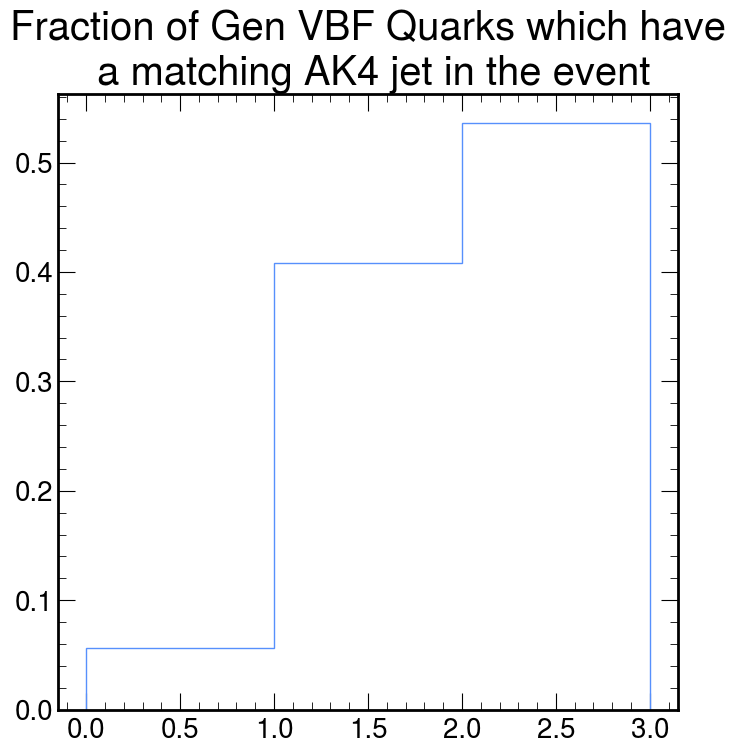

In [10]:
plt.figure(figsize=(8, 8))
plt.hist(
    ak.sum(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1),
    [0, 1, 2, 3],
    histtype="step",
    density=True,
)
plt.title("Fraction of Gen VBF Quarks which have\n a matching AK4 jet in the event")
plt.savefig(plot_dir / "gen_matching_fraction.pdf", bbox_inches="tight")
plt.show()

Leptons

In [11]:
electrons_dict = {}
muons_dict = {}
sel_electrons_dict = {}
sel_muons_dict = {}

for key, events in events_dict.items():
    electrons = events.Electron
    electrons = electrons[(electrons.pt > 5) & (electrons.cutBased >= electrons.LOOSE)]

    muons = events.Muon
    muons = muons[(muons.pt > 7) & (muons.looseId)]

    electrons_dict[key] = electrons
    muons_dict[key] = muons

    sel = sel_dict[key]
    sel_electrons_dict[key] = electrons[sel]
    sel_muons_dict[key] = muons[sel]

# Matching Efficiency and significance

In [12]:
def matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4, num_jets: int = 2) -> float:
    drs = ak.pad_none(vbf_jets, num_jets, axis=1)[:, :num_jets].metric_table(gen_quarks)
    matched = drs < matching_dr

    # TODO: add overlap removal?
    matching_fraction = np.mean(np.all(np.any(matched, axis=2), axis=1))
    return matching_fraction

In [24]:
from typing import Callable, Dict, Tuple, Union


def significance(
    sel_vbf_jets: ak.Array,
    sel_bkg_jets_dict: Dict[str, ak.Array],
    selection: Callable[ak.Array, ak.Array] = lambda jets: jets[ak.count(jets.pt, axis=1) > 1],
    verbose: bool = False,
    return_effs: bool = False,  # if true, return (signfiance, signal_eff, bkg_eff)
) -> Union[float, Tuple[float, float, float]]:
    total_vbf_events = len(sel_vbf_jets)
    total_vbf_selected = len(selection(sel_vbf_jets))
    signal_efficiency = total_vbf_selected / total_vbf_events
    if verbose:
        print(f"Number of total VBF events: {total_vbf_events}")
        print(f"Number of selected VBF jets: {total_vbf_selected}")
        print(f"Signal efficiency: {signal_efficiency}")

    # background efficiency
    total_bkg_events = 0
    total_bkg_selected = 0
    for key, bkg_events in sel_bkg_jets_dict.items():
        sel_bkg_jets = sel_bkg_jets_dict[key]
        k_total_bkg_events = len(bkg_events)
        k_total_bkg_selected = len(selection(sel_bkg_jets))
        total_bkg_events += k_total_bkg_events
        total_bkg_selected += k_total_bkg_selected
        if verbose:
            print(f"Number of total background events for {key}: {k_total_bkg_events}")
            print(f"Number of selected background jets for {key}: {k_total_bkg_selected}")
            print(f"Background efficiency for {key}: {k_total_bkg_selected / k_total_bkg_events}")

    background_efficiency = total_bkg_selected / total_bkg_events
    if verbose:
        print(f"Total number of background events: {total_bkg_events}")
        print(f"Total number of selected background jets: {total_bkg_selected}")
        print(f"Background efficiency: {background_efficiency}")

    # S/sqrt(B)
    # sig = signal_efficiency / np.sqrt(background_efficiency)
    sig = total_vbf_selected / np.sqrt(total_bkg_selected)

    if return_effs:
        return sig, signal_efficiency, background_efficiency
    else:
        return sig


def selection_2jets(jets):
    return jets[ak.count(jets.pt, axis=1) > 1]


def selection_2jets_etajj(jets, min_eta_jj: float = 3) -> ak.Array:
    jets = selection_2jets(jets)
    return jets[np.abs(jets[:, 0].eta - jets[:, 1].eta) > min_eta_jj]

## AK4 jet selections

In [25]:
# ak4_jet_selection = {  # noqa: RUF012
#     "pt": 15,
#     "eta_min": 1,
#     "eta_max": 5.1,
#     # "jetId": "tight",
#     # "puId": "medium",
#     "dR_fatjetbb": 1.1,
#     "dR_fatjetVV": 1.0,
# }

ak4_jet_selection = {
    "pt": 25,
    "eta_min": 0,
    "eta_max": 4.7,
    "jetId": "tight",
    "puId": "medium",
    "dR_fatjetbb": 1.2,
    "dR_fatjetVV": 0.8,
}

sel_jets_dict = {}
sel_mask_dict = {}

# perform AK4 jet selection for each event
for key, events in sel_events_dict.items():
    jets = events.Jet
    bbjet = sel_bbjet_dict[key]
    vvjet = sel_vvjet_dict[key]
    electrons = sel_electrons_dict[key]
    muons = sel_muons_dict[key]

    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    sel_mask = (
        # jets.isTight
        (jets.pt >= ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
        & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )

    sel_jets = jets[sel_mask]

    sel_jets_dict[key] = sel_jets
    sel_mask_dict[key] = sel_mask

# calculate significance
sel_vbf_jets = sel_jets_dict["vbf"]
sel_bkg_jets_dict = {k: v for k, v in sel_jets_dict.items() if k != "vbf"}

print("Select events with at least 2 jets")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

print("=" * 80)
print("Select events with at least 2 jets and |eta_jj| > 3")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets_etajj,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

Select events with at least 2 jets
Significance: 35.285694843723576
True Positive Rate: 0.8238042880703683
False Positive Rate: 0.5011810476587467
Select events with at least 2 jets and |eta_jj| > 3
Significance: 63.262827202012375
True Positive Rate: 0.6819681143485432
False Positive Rate: 0.10685007642073086


## Optimizing Selections

### Selecting an event with at least 2 jets
Optimizing for `(pt, etamin, etamax, bbdr, vvdr, tightID, pileUpID)`

In [ ]:
from itertools import product

sig_dict = {
    "pt": None,
    "etamin": None,
    "etamax": None,
    "bbdr": None,
    "vvdr": None,
    "puID": None,
    "tightID": None,
    "significance": 0,
}
# optimize fatjet dR and eta cuts together
pt_list = np.arange(15, 35, 5)
etamin_list = np.arange(0, 2, 0.2)
etamax_list = np.arange(4, 5.2, 0.2)
bbdr_list = np.arange(0, 2, 0.2)
vvdr_list = np.arange(0, 2, 0.2)
# puID_list = (True, False)
# tightID_list = (True, False)
# They turned out to be useful
puID_list = (True,)
tightID_list = (True,)
total = (
    len(pt_list)
    * len(etamin_list)
    * len(etamax_list)
    * len(bbdr_list)
    * len(vvdr_list)
    * len(puID_list)
    * len(tightID_list)
)

for etamin, bbdr, vvdr, puID, tightID in tqdm(
    product(etamin_list, bbdr_list, vvdr_list, puID_list, tightID_list), total=total
):
    ak4_jet_selection = {  # noqa: RUF012
        "pt": 15,
        "eta_min": etamin,
        "eta_max": 5.1,
        # "jetId": "tight",
        # "puId": "medium",
        "dR_fatjetbb": bbdr,
        "dR_fatjetVV": vvdr,
    }

    # perform AK4 jet selection for each type
    sel_jets_dict = {}
    sel_mask_dict = {}
    for key, events in sel_events_dict.items():
        jets = events.Jet
        bbjet = sel_bbjet_dict[key]
        vvjet = sel_vvjet_dict[key]
        electrons = sel_electrons_dict[key]
        muons = sel_muons_dict[key]
        # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
        # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
        # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
        sel_mask = (
            # jets.isTight
            (jets.pt >= ak4_jet_selection["pt"])
            & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
            & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
            # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
            # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
            & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
            & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
            & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
            & ak.all(jets.metric_table(muons) > 0.4, axis=2)
        )
        if tightID:
            sel_mask = sel_mask & jets.isTight
        if puID:
            sel_mask = sel_mask & ((jets.pt > 50) | ((jets.puId & 2) == 2))

        sel_jets = jets[sel_mask]
        sel_jets_dict[key] = sel_jets
        sel_mask_dict[key] = sel_mask

    # calculate significance
    sel_vbf_jets = sel_jets_dict["vbf"]
    sel_bkg_jets_dict = {k: v for k, v in sel_jets_dict.items() if k != "vbf"}

    sig = significance(
        sel_vbf_jets=sel_vbf_jets,
        sel_bkg_jets_dict=sel_bkg_jets_dict,
        selection=selection_2jets,
        verbose=False,
        return_effs=False,
    )

    if sig > sig_dict["significance"]:
        sig_dict["etamin"] = etamin
        sig_dict["bbdr"] = bbdr
        sig_dict["vvdr"] = vvdr
        sig_dict["puID"] = puID
        sig_dict["tightID"] = tightID
        sig_dict["significance"] = sig

print(sig_dict)

### Select events with at least 2 jets and $ \eta_{jj} > 3$
Optimizing for `(pt, etamin, etamax, bbdr, vvdr, tightID, pileUpID)`

In [ ]:
from itertools import product

sig_dict = {
    "pt": None,
    "etamin": None,
    "etamax": None,
    "bbdr": None,
    "vvdr": None,
    "puID": None,
    "tightID": None,
    "significance": 0,
}
# optimize fatjet dR and eta cuts together
pt_list = np.arange(15, 35, 5)
etamin_list = np.arange(0, 2, 0.1)
etamax_list = np.arange(4, 5.2, 0.1)
bbdr_list = np.arange(0, 2, 0.1)
vvdr_list = np.arange(0, 2, 0.1)
# puID_list = (True, False)
# tightID_list = (True, False)
# They turned out to be useful
puID_list = (True,)
tightID_list = (True,)
total = (
    len(pt_list)
    * len(etamin_list)
    * len(etamax_list)
    * len(bbdr_list)
    * len(vvdr_list)
    * len(puID_list)
    * len(tightID_list)
)

for etamin, bbdr, vvdr, puID, tightID in tqdm(
    product(etamin_list, bbdr_list, vvdr_list, puID_list, tightID_list), total=total
):
    ak4_jet_selection = {  # noqa: RUF012
        "pt": 15,
        "eta_min": etamin,
        "eta_max": 5.1,
        # "jetId": "tight",
        # "puId": "medium",
        "dR_fatjetbb": bbdr,
        "dR_fatjetVV": vvdr,
    }

    # perform AK4 jet selection for each type
    sel_jets_dict = {}
    sel_mask_dict = {}
    for key, events in sel_events_dict.items():
        jets = events.Jet
        bbjet = sel_bbjet_dict[key]
        vvjet = sel_vvjet_dict[key]
        electrons = sel_electrons_dict[key]
        muons = sel_muons_dict[key]
        # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
        # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
        # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
        sel_mask = (
            # jets.isTight
            (jets.pt >= ak4_jet_selection["pt"])
            & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
            & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
            # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
            # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
            & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
            & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
            & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
            & ak.all(jets.metric_table(muons) > 0.4, axis=2)
        )
        if tightID:
            sel_mask = sel_mask & jets.isTight
        if puID:
            sel_mask = sel_mask & ((jets.pt > 50) | ((jets.puId & 2) == 2))

        sel_jets = jets[sel_mask]
        sel_jets_dict[key] = sel_jets
        sel_mask_dict[key] = sel_mask

    # calculate significance
    sel_vbf_jets = sel_jets_dict["vbf"]
    sel_bkg_jets_dict = {k: v for k, v in sel_jets_dict.items() if k != "vbf"}

    sig = significance(
        sel_vbf_jets=sel_vbf_jets,
        sel_bkg_jets_dict=sel_bkg_jets_dict,
        selection=selection_2jets_etajj,
        verbose=False,
        return_effs=False,
    )

    if sig > sig_dict["significance"]:
        sig_dict["etamin"] = etamin
        sig_dict["bbdr"] = bbdr
        sig_dict["vvdr"] = vvdr
        sig_dict["puID"] = puID
        sig_dict["tightID"] = tightID
        sig_dict["significance"] = sig

print(sig_dict)

## Final Selection

In [ ]:
# # Original selection
# ak4_jet_selection = {
#     "pt": 25,
#     "eta_min": 0,
#     "eta_max": 4.7,
#     "jetId": "tight",
#     "puId": "medium",
#     "dR_fatjetbb": 1.2,
#     "dR_fatjetVV": 0.8,
# }

# # ZH's efficiency optimization
# ak4_jet_selection = {  # noqa: RUF012
#     "pt": 15,
#     "eta_min": 0.95,
#     "eta_max": 5.1,
#     # "jetId": "tight",
#     # "puId": "medium",
#     "dR_fatjetbb": 1.39,
#     "dR_fatjetVV": 1.39,
# }

# # RK's efficiency optimization
# ak4_jet_selection = {  # noqa: RUF012
#     "pt": 15,
#     "eta_min": 1,
#     "eta_max": 5.1,
#     # "jetId": "tight",
#     # "puId": "medium",
#     "dR_fatjetbb": 1.1,
#     "dR_fatjetVV": 1.0,
# }

# # ZH's significance optimization for selection=selection_2jets
# ak4_jet_selection = {  # noqa: RUF012
#     "pt": 15,
#     "eta_min": 1.95,
#     "eta_max": 5.1,
#     # "jetId": "tight",
#     # "puId": "medium",
#     "dR_fatjetbb": 1.25,
#     "dR_fatjetVV": 1.35,
# }

# # ZH's significance optimization for selection=selection_2jets_etajj
ak4_jet_selection = {
    "pt": 30,
    "eta_min": 1.8,
    "eta_max": 5.0,
    "dR_fatjetbb": 1.8,
    "dR_fatjetVV": 1.8,
}

# find selected jets for each type
sel_jets_dict = {}
sel_mask_dict = {}
for key, events in sel_events_dict.items():
    jets = events.Jet
    bbjet = sel_bbjet_dict[key]
    vvjet = sel_vvjet_dict[key]
    electrons = sel_electrons_dict[key]
    muons = sel_muons_dict[key]
    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    sel_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
        & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )
    sel_jets = jets[sel_mask]
    sel_jets_dict[key] = sel_jets
    sel_mask_dict[key] = sel_mask

# calculate significance
sel_vbf_jets = sel_jets_dict["vbf"]
sel_bkg_jets_dict = {k: v for k, v in sel_jets_dict.items() if k != "vbf"}

print("Select events with at least 2 jets")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

print("=" * 80)
print("Select events with at least 2 jets and |eta_jj| > 3")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets_etajj,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

In [ ]:
matching_efficiency(sel_gen_quarks, sel_vbf_jets)

### Statistics

In [ ]:
jets = events_dict["vbf"].Jet
drs = jets.metric_table(gen_quarks)
matched = ak.any(drs < 0.4, axis=2)

sel = sel_dict["vbf"]
sel_jets = jets[sel]
sel_drs = sel_jets.metric_table(sel_gen_quarks)
sel_matched = ak.any(sel_drs < 0.4, axis=2)

vbf_jet_mask = sel_mask_dict["vbf"]
vbf_jets = sel_jets_dict["vbf"]

In [ ]:
# selected VBF jets
vbf_jets_selected = sel_jets[vbf_jet_mask][:, :2][sel_matched[vbf_jet_mask][:, :2]]
# VBF jets that were not selected by AK4 selection
vbf_jets_unselected_ak4 = sel_jets[~vbf_jet_mask][sel_matched[~vbf_jet_mask]]
# VBF jets that were selected by AK4 selection but unselected by pT selection
vbf_jets_unselected_pt = sel_jets[vbf_jet_mask][:, 2:][sel_matched[vbf_jet_mask][:, 2:]]
# Fake VBF jets that were selected
fake_jets_selected = sel_jets[vbf_jet_mask][:, :2][~sel_matched[vbf_jet_mask][:, :2]]

tot = len(sel_mask_dict["vbf"])
twosel = ak.count(vbf_jets_selected.pt, axis=1) == 2
onesel = ak.count(vbf_jets_selected.pt, axis=1) == 1
unsak4 = ak.count(vbf_jets_unselected_ak4.pt, axis=1) == 1
unspt = ak.count(vbf_jets_unselected_pt.pt, axis=1) == 1
zsel = ak.count(vbf_jets_selected.pt, axis=1) == 0

print(
    "Events with two true VBF jets selected:", np.sum(twosel), f"({np.sum(twosel)/ tot * 100:.1f}%)"
)
print(
    "Events with 1 VBF jet unselected because ak4 selections:",
    np.sum(unsak4),
    f"({np.sum(unsak4)/ tot * 100:.1f}%)",
)
print(
    "Events with 1 VBF jet unselected because pt:",
    np.sum(unspt),
    f"({np.sum(unspt)/ tot * 100:.1f}%)",
)
print("Events with 0 true VBF jets selected:", np.sum(zsel), f"({np.sum(zsel)/ tot * 100:.1f}%)")

Choosing highest eta_jj pair of jets

In [ ]:
def highest_etajj_pair(jets, num_jets=3, matched=None):
    # Pad the jets array with None values to ensure a fixed size
    jets = ak.pad_none(jets, num_jets, clip=True)
    etas = jets.eta
    # Pairwise eta differences
    # etas = ak.pad_none(jets.eta, num_jets, clip=True)
    ed = ak.fill_none(np.abs(etas[:, :, None] - etas[:, None]), 0)
    # choose the pair that has the largest eta_jj
    am = np.argmax(ak.flatten(ed, axis=2), axis=1)
    # Get the corresponding jets for the highest eta difference pair
    i1 = am // num_jets
    i2 = am % num_jets
    j1 = jets[np.arange(len(jets)), i1.to_numpy()]
    j2 = jets[np.arange(len(jets)), i2.to_numpy()]

    selected_jets = ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1)

    if matched is not None:
        # Get the matched values for the highest eta difference pair
        # matched1 = ak.pad_none(matched[sel][vbf_jet_mask], num_jets, clip=True)[
        #     np.arange(ak.sum(sel)), i1.to_numpy()
        # ]
        # matched2 = ak.pad_none(matched[sel][vbf_jet_mask], num_jets, clip=True)[
        #     np.arange(ak.sum(sel)), i2.to_numpy()
        # ]
        matched1 = ak.pad_none(matched, num_jets, clip=True)[np.arange(len(matched)), i1.to_numpy()]
        matched2 = ak.pad_none(matched, num_jets, clip=True)[np.arange(len(matched)), i2.to_numpy()]

        selected_indices = ak.concatenate([ak.unflatten(i1, 1), ak.unflatten(i2, 1)], axis=1)
        selected_matched = ak.concatenate(
            [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
        )

        # return ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1), ak.concatenate(
        #     [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
        # )
        return selected_indices, selected_jets, selected_matched
    else:
        return selected_jets

In [ ]:
# perform selection on the background jets
selected_bkgs = {}
for k, bkg_jets in sel_bkg_jets_dict.items():
    selected_bkgs[k] = highest_etajj_pair(bkg_jets, matched=None)

print("Select events with at least 2 jets")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=selected_jets,
    sel_bkg_jets_dict=selected_bkgs,
    selection=selection_2jets,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

print("=" * 80)
print("Select events with at least 2 jets and |eta_jj| > 3")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=selected_jets,
    sel_bkg_jets_dict=selected_bkgs,
    selection=selection_2jets_etajj,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

In [ ]:
selected_indices, selected_jets, selected_matched = highest_etajj_pair(
    vbf_jets, matched=sel_matched[vbf_jet_mask]
)
matching_efficiency(sel_gen_quarks, selected_jets)

Choosing highest pT pair of jets with a minimum eta_jj value

In [ ]:
from typing import Optional


def top_pt_eta_min(
    jets: ak.Array, eta_jj_min: float = 2.0, num_jets: int = 3, matched: Optional[ak.Array] = None
):
    """
    Find highest pt pair of jets with |eta_jj| > eta_jj_min.
    If no such pair is found, return the pair with the highest pt.
    If `matched` is provided, return (selected_indices, selected_jets, selected_matched).
    Otherwise, return selected_jets.
    """
    jets = ak.pad_none(jets, num_jets, clip=True)
    eta = jets.eta

    etas = []
    i_s = []
    for i in range(num_jets):
        for j in range(i + 1, num_jets):
            etajj = ak.fill_none(np.abs(eta[:, i] - eta[:, j]) >= eta_jj_min, False)
            etas.append(etajj)
            i_s.append([i, j])

    inds = np.zeros((len(jets), 2))
    inds[:, 1] += 1

    eta_jj_cache = ~etas[0]
    for n in range(1, len(etas)):
        inds[eta_jj_cache * etas[n]] = i_s[n]
        eta_jj_cache = eta_jj_cache * ~etas[n]

    i1 = inds[:, 0].astype(int)
    i2 = inds[:, 1].astype(int)

    j1 = jets[np.arange(len(jets)), i1]
    j2 = jets[np.arange(len(jets)), i2]

    selected_jets = ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1)

    if matched is None:
        return selected_jets
    else:
        matched1 = ak.pad_none(matched, num_jets, clip=True)[np.arange(len(matched)), i1]
        matched2 = ak.pad_none(matched, num_jets, clip=True)[np.arange(len(matched)), i2]

        selected_indices = ak.concatenate([ak.unflatten(i1, 1), ak.unflatten(i2, 1)], axis=1)
        selected_matched = ak.concatenate(
            [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
        )

        return selected_indices, selected_jets, selected_matched

In [ ]:
selected_indices, selected_jets, selected_matched = top_pt_eta_min(
    vbf_jets,
    eta_jj_min=3,
    num_jets=4,
    matched=sel_matched[vbf_jet_mask],
)
matching_efficiency(sel_gen_quarks, selected_jets)

In [ ]:
max_matching = [0, 0, 0]
best_selected_indices = None
best_selected_jets = None
best_selected_bkg = None
best_selected_matched = None
for etamin in tqdm(np.arange(1, 5, 0.05)):
    for num_jets in np.arange(2, 5, 1):
        # VBF
        selected_jets = top_pt_eta_min(
            vbf_jets,
            eta_jj_min=etamin,
            num_jets=num_jets,
            matched=None,
        )
        # Background
        selected_bkg_dict = {}
        for k, bkg_jets in sel_bkg_jets_dict.items():
            selected_bkgs = top_pt_eta_min(
                bkg_jets,
                eta_jj_min=etamin,
                num_jets=num_jets,
                matched=None,
            )
            selected_bkg_dict[k] = selected_bkgs
        sig = significance(
            sel_vbf_jets=selected_jets,
            sel_bkg_jets_dict=selected_bkg_dict,
            selection=selection_2jets_etajj,
            # selection=selection_2jets,
            verbose=False,
            return_effs=False,
        )
        if sig > max_matching[-1]:
            max_matching = [etamin, num_jets, sig]
            best_selected_indices = selected_indices
            best_selected_jets = selected_jets
            best_selected_bkg = selected_bkg_dict
            best_selected_matched = selected_matched

etamin, num_jets, sig = max_matching
selected_indices = best_selected_indices
selected_jets = best_selected_jets
selected_bkg_dict = best_selected_bkg
selected_matched = best_selected_matched
print(f"{etamin=}, {num_jets=}, {sig=}")

In [ ]:
print("Select events with at least 2 jets")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=selected_jets,
    sel_bkg_jets_dict=selected_bkg_dict,
    selection=selection_2jets,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

print("=" * 80)
print("Select events with at least 2 jets and |eta_jj| > 3")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=selected_jets,
    sel_bkg_jets_dict=selected_bkg_dict,
    selection=selection_2jets_etajj,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

# Summary

In [ ]:
ak4_jet_selection = {
    "pt": 30,
    "eta_min": 1.8,
    "eta_max": 5.0,
    "dR_fatjetbb": 1.8,
    "dR_fatjetVV": 1.8,
}

# find selected jets for each type
sel_jets_dict = {}
sel_mask_dict = {}
for key, events in sel_events_dict.items():
    jets = events.Jet
    bbjet = sel_bbjet_dict[key]
    vvjet = sel_vvjet_dict[key]
    electrons = sel_electrons_dict[key]
    muons = sel_muons_dict[key]
    # dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
    # https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
    # (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
    sel_mask = (
        jets.isTight
        & (jets.pt >= ak4_jet_selection["pt"])
        & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
        & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
        & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )
    sel_jets = jets[sel_mask]
    sel_jets_dict[key] = sel_jets
    sel_mask_dict[key] = sel_mask

sel_bkg_jets_dict = {k: v for k, v in sel_jets_dict.items() if k != "vbf"}

jets = events_dict["vbf"].Jet
drs = jets.metric_table(gen_quarks)
matched = ak.any(drs < 0.4, axis=2)

sel = sel_dict["vbf"]
sel_jets = jets[sel]
sel_drs = sel_jets.metric_table(sel_gen_quarks)
sel_matched = ak.any(sel_drs < 0.4, axis=2)

vbf_jet_mask = sel_mask_dict["vbf"]
vbf_jets = sel_jets_dict["vbf"]


selected_indices, sel_vbf_jets, selected_matched = top_pt_eta_min(
    vbf_jets, matched=sel_matched[vbf_jet_mask], eta_jj_min=3, num_jets=4
)

In [ ]:
matching_efficiency(sel_gen_quarks, sel_vbf_jets)

In [ ]:
print("Select events with at least 2 jets")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

print("=" * 80)
print("Select events with at least 2 jets and |eta_jj| > 3")
sig, sig_eff, bkg_eff = significance(
    sel_vbf_jets=sel_vbf_jets,
    sel_bkg_jets_dict=sel_bkg_jets_dict,
    selection=selection_2jets_etajj,
    verbose=False,
    return_effs=True,
)
print(f"Significance: {sig}")
print(f"True Positive Rate: {sig_eff}")
print(f"False Positive Rate: {bkg_eff}")

In [ ]:
tot = len(selected_matched)
twosel = ak.sum(selected_matched, axis=1) == 2
onesel = ak.sum(selected_matched, axis=1) == 1
zsel = ak.sum(selected_matched, axis=1) == 0

print(
    "Events with two true VBF jets selected:", np.sum(twosel), f"({np.sum(twosel)/ tot * 100:.1f}%)"
)
print("Events with 1 true VBF selected:", np.sum(onesel), f"({np.sum(onesel)/ tot * 100:.1f}%)")
print("Events with 0 true VBF jets selected:", np.sum(zsel), f"({np.sum(zsel)/ tot * 100:.1f}%)")

In [ ]:
# fake_jets_selected = vbf_jets[onesel][~selected_matched[onesel]]
# true_jets_selected = vbf_jets[onesel][selected_matched[onesel]]

true_selected_list = []
fake_selected_list = []
true_unselected_list = []

for i in range(len(vbf_jets[onesel])):
    event = vbf_jets[onesel][i]
    event_matched = sel_matched[vbf_jet_mask][onesel][i]
    event_selected = selected_indices[onesel][i]

    event_true_selected_list = []
    event_fake_selected_list = []
    event_true_unselected_list = []

    for j in range(len(event)):
        jet = event[j]
        is_matched = event_matched[j]
        is_selected = j in event_selected

        if is_matched and is_selected:
            event_true_selected_list.append(jet)
        elif not is_matched and is_selected:
            event_fake_selected_list.append(jet)
        elif is_matched and not is_selected:
            event_true_unselected_list.append(jet)

    true_selected_list.append(event_true_selected_list)
    fake_selected_list.append(event_fake_selected_list)
    true_unselected_list.append(event_true_unselected_list)

true_jets_selected = ak.Array(true_selected_list)
fake_jets_selected = ak.Array(fake_selected_list)
true_jets_unselected = ak.Array(true_unselected_list)

In [ ]:
plt.figure(figsize=(10, 10))
bins = np.arange(0, 40, 1)
plt.hist(
    ak.flatten(true_jets_selected.mass),
    bins=bins,
    histtype="step",
    label="True VBF Jets Selected",
    density=True,
)
plt.hist(
    ak.flatten(fake_jets_selected.mass),
    bins=bins,
    histtype="step",
    label="Fake VBF Jets Selected",
    density=True,
)
plt.hist(
    ak.flatten(true_jets_unselected.mass),
    bins=bins,
    histtype="step",
    label="True VBF Jets Unselected",
    density=True,
)
plt.title("Selected VBF Jets")
plt.xlabel("Jet Mass (GeV)")
plt.ylabel("Number of Jets (A. U.)")
plt.legend()
plt.savefig(plot_dir / "selected_jets_mass.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
bins = np.arange(0, 300, 10)
plt.hist(
    ak.flatten(true_jets_selected.pt),
    bins=bins,
    histtype="step",
    label="True VBF Jets Selected",
    density=True,
)
plt.hist(
    ak.flatten(fake_jets_selected.pt),
    bins=bins,
    histtype="step",
    label="Fake VBF Jets Selected",
    density=True,
)
plt.hist(
    ak.flatten(true_jets_unselected.pt),
    bins=bins,
    histtype="step",
    label="True VBF Jets Unselected",
    density=True,
)
plt.title("Selected VBF Jets")
plt.xlabel("Jet $p_T$ (GeV)")
plt.ylabel("Number of Jets (A. U.)")
plt.legend()
plt.savefig(plot_dir / "selected_jets_pt.pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
bins = np.arange(1.5, 5.5, 0.2)
plt.hist(
    np.abs(ak.flatten(true_jets_selected.eta)),
    bins=bins,
    histtype="step",
    label="True VBF Jets Selected",
    density=True,
)
plt.hist(
    np.abs(ak.flatten(fake_jets_selected.eta)),
    bins=bins,
    histtype="step",
    label="Fake VBF Jets Selected",
    density=True,
)
plt.hist(
    np.abs(ak.flatten(true_jets_unselected.eta)),
    bins=bins,
    histtype="step",
    label="True VBF Jets Unselected",
    density=True,
)
plt.title("Selected VBF Jets")
plt.xlabel("Jet $|\eta|$")
plt.ylabel("Number of Jets (A. U.)")
plt.legend()
plt.savefig(plot_dir / "selected_jets_eta.pdf", bbox_inches="tight")
plt.show()

eta_jj cut efficiency

In [ ]:
etas = pad_val(vbf_jets.eta, 2, axis=1)
eta_jj = np.abs(etas[:, 0] - etas[:, 1])
np.mean(eta_jj > 4)

In [ ]:
etas = pad_val(vbf_jets[ak.fill_none((ak.count(vbf_jets.pt, axis=1) >= 2), False)].eta, 2, axis=1)

etas = pad_val(vbf_jets.eta, 2, axis=1)

plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
plt.hist(np.abs(etas[:, 0] - etas[:, 1]), np.arange(0, 10, 0.25), histtype="step", density=True)
plt.xlabel(r"$\eta_{jj}$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "selection_eta_jj.pdf", bbox_inches="tight")
plt.show()

In [ ]:
def select_highest_pt_pair(jets, eta_jj_threshold=2.0, max_jets=3, matched=None):
    """
    Select the pair of jets with the highest pt that satisfies the eta_jj threshold.
    """
    # Pad or truncate the jets array to have a length of max_jets
    jets = ak.pad_none(jets, max_jets, clip=True)
    eta = jets.eta

    # Calculate the absolute eta difference for all possible pairs of jets
    eta_jjs = [
        np.abs(eta[:, i] - eta[:, j]) for i in range(max_jets) for j in range(i + 1, max_jets)
    ]

    # Create a boolean mask indicating which pairs satisfy the eta_jj threshold
    eta_jj_mask = [ak.fill_none(jj >= eta_jj_threshold, False) for jj in eta_jjs]

    # Initialize the indices of the selected jet pair
    indices = np.zeros((len(jets), 2), dtype=int)
    indices[:, 1] = 1

    # Iterate over the eta_jj masks and update the indices
    for mask, (i, j) in zip(
        eta_jj_mask, [(i, j) for i in range(max_jets) for j in range(i + 1, max_jets)]
    ):
        indices[mask] = [i, j]

    # Get the selected jets and their corresponding indices
    jet1 = jets[np.arange(len(jets)), indices[:, 0]]
    jet2 = jets[np.arange(len(jets)), indices[:, 1]]
    selected_jets = ak.concatenate([ak.unflatten(jet1, 1), ak.unflatten(jet2, 1)], axis=1)

    if matched is not None:
        matched = ak.pad_none(matched, max_jets, clip=True)
        matched1 = matched[np.arange(len(matched)), indices[:, 0]]
        matched2 = matched[np.arange(len(matched)), indices[:, 1]]
        selected_matched = ak.concatenate(
            [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
        )
        return indices, selected_jets, selected_matched
    else:
        return selected_jets